c:\Users\51648\Documents\GitHub\ML4MSD-HW-YueZ\.venv\Lib\site-packages\matminer\utils\data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


ElementProperty:   0%|          | 0/500 [00:00<?, ?it/s]

Number of features before cleaning: 137
Number of features after removing small variance columns: 131
Number of features after removing highly correlated columns: 117


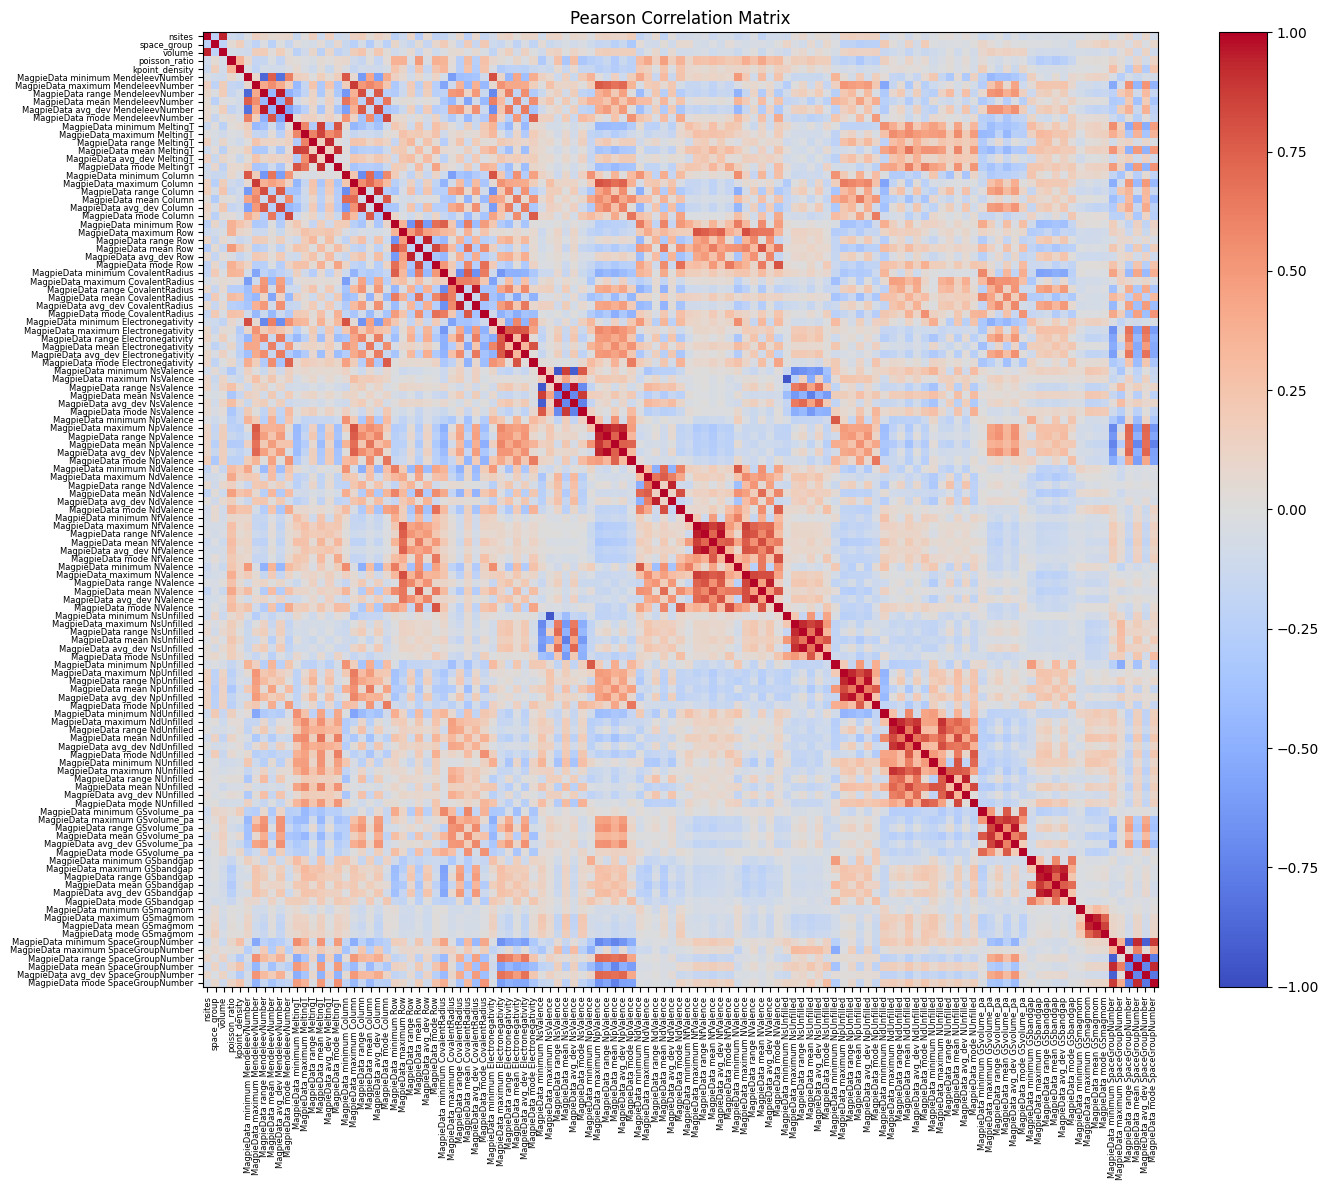

In [27]:
from matminer.datasets.dataset_retrieval import load_dataset
from matminer.featurizers.composition.composite import ElementProperty
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from tqdm.notebook import tqdm
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score

df_full = load_dataset('elastic_tensor_2015')
n_sample = 500
df = df_full.sample(n=n_sample, random_state=17) 
df_comp = df.copy()
df_comp['composition'] = df_comp.structure.apply(lambda x: x.composition )

el_prop_featuriser = ElementProperty.from_preset(preset_name='magpie', impute_nan=False)
el_prop_featuriser.set_n_jobs(1)
df_featurized = el_prop_featuriser.featurize_dataframe(df_comp, col_id='composition')


y = df_featurized['K_VRH']
cols_to_drop = [
    'elastic_anisotropy', 'G_Reuss', 'G_VRH', 'G_Voigt',
    'K_Reuss', 'K_Voigt', 'elastic_tensor', 'compliance_tensor'
]
X_all = df_featurized.drop(columns=cols_to_drop, errors='ignore')
X_all = X_all.select_dtypes(include=['float64', 'int64'])
X_all = X_all.drop(columns='K_VRH', errors='ignore')
print("Number of features before cleaning:", X_all.shape[1])

small_var_cols = X_all.columns[X_all.var() < 1e-5].tolist()
X_all = X_all.drop(columns=small_var_cols)
print("Number of features after removing small variance columns:", X_all.shape[1])

corr_matrix = X_all.corr(method='pearson')
threshold = 0.99
to_drop = set()
for col in corr_matrix.columns:
    high_corr = corr_matrix.index[(corr_matrix[col].abs() > threshold) & (corr_matrix.index != col)]
    to_drop.update(high_corr)
X = X_all.drop(columns=list(to_drop))
print("Number of features after removing highly correlated columns:", X.shape[1])

corr_matrix = X.corr(method='pearson')

plt.figure(figsize=(16, 12))
im = plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title('Pearson Correlation Matrix')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90, fontsize=6)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns, fontsize=6)
plt.tight_layout()
plt.show()

Training fraction: 0.70
Validation fraction: 0.20
Test fraction: 0.10
Baseline MAE : 58.9539 eV


Training RF models:   0%|          | 0/4 [00:00<?, ?it/s]

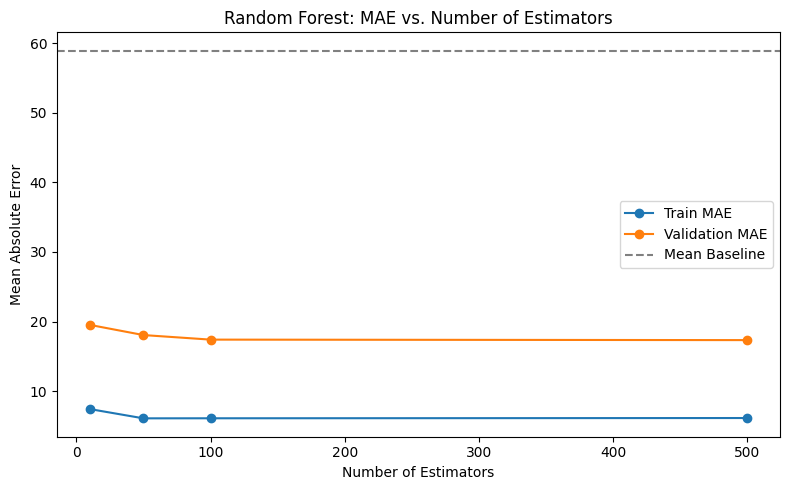

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

test_fraction = 0.1
validation_fraction = 0.2
X_trainval, X_test, y_trainval, y_test = train_test_split(X_scaled, y, 
                                                          test_size=test_fraction, 
                                                          random_state=17)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, 
                                                  test_size=validation_fraction/(1-test_fraction), 
                                                  random_state=17)
print(f"Training fraction: {X_train.shape[0] / X_scaled.shape[0]:.2f}")
print(f"Validation fraction: {X_val.shape[0] / X_scaled.shape[0]:.2f}")
print(f"Test fraction: {X_test.shape[0] / X_scaled.shape[0]:.2f}")

mean_train = y_train.mean()
baseline_mae = mean_absolute_error(y_val, [mean_train] * len(y_val))
print(f"Baseline MAE : {baseline_mae:.4f} eV")

n_estimators_list = [10, 50, 100, 500]
train_maes = []
val_maes = []

for n in tqdm(n_estimators_list, desc='Training RF models'):
    rf = RandomForestRegressor(n_estimators=n, random_state=17, n_jobs=1)
    rf.fit(X_train, y_train)
    y_train_pred = rf.predict(X_train)
    y_val_pred = rf.predict(X_val)
    train_maes.append(mean_absolute_error(y_train, y_train_pred))
    val_maes.append(mean_absolute_error(y_val, y_val_pred))

plt.figure(figsize=(8, 5))
plt.plot(n_estimators_list, train_maes, marker='o', label='Train MAE')
plt.plot(n_estimators_list, val_maes, marker='o', label='Validation MAE')
plt.axhline(baseline_mae, color='gray', linestyle='--', label='Mean Baseline')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Absolute Error')
plt.title('Random Forest: MAE vs. Number of Estimators')
plt.legend()
plt.tight_layout()
plt.show()

RFE Progress:   0%|          | 0/23 [00:00<?, ?it/s]

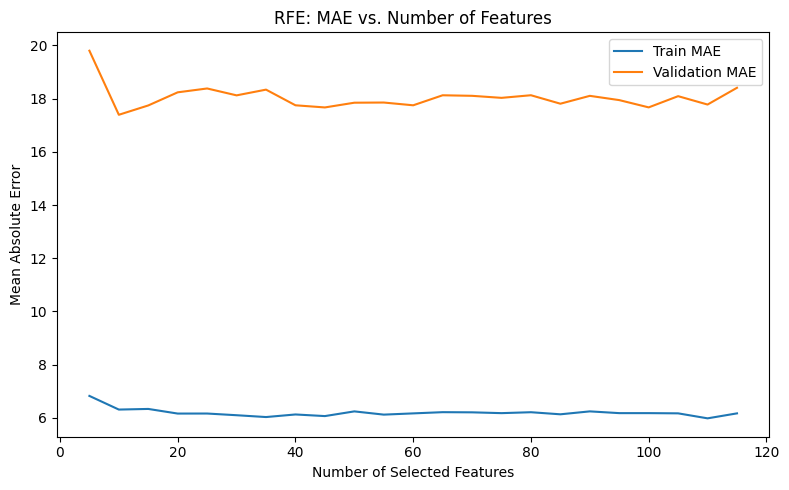

In [5]:
rf = RandomForestRegressor(n_estimators=50, random_state=17, n_jobs=1)
n_features_list = list(range(5, X_val.shape[1]+1, 5))
val_errors = []
train_errors = []
selected_features_dict = {}

for n_features in tqdm(n_features_list, desc='RFE Progress'):
    rfe = RFE(estimator=rf, n_features_to_select=n_features, step=5)
    rfe.fit(X_train, y_train)
    selected_features_dict[n_features] = list(X.columns[rfe.support_])
    X_train_rfe = rfe.transform(X_train)
    rf.fit(X_train_rfe, y_train)
    y_train_pred = rf.predict(X_train_rfe)
    train_errors.append(mean_absolute_error(y_train, y_train_pred))
    X_val_rfe = rfe.transform(X_val)
    y_val_pred = rf.predict(X_val_rfe)
    val_errors.append(mean_absolute_error(y_val, y_val_pred))

plt.figure(figsize=(8, 5))
plt.plot(n_features_list, train_errors, label='Train MAE')
plt.plot(n_features_list, val_errors, label='Validation MAE')
plt.xlabel('Number of Selected Features')
plt.ylabel('Mean Absolute Error')
plt.title('RFE: MAE vs. Number of Features')
plt.legend()
plt.tight_layout()
plt.show()

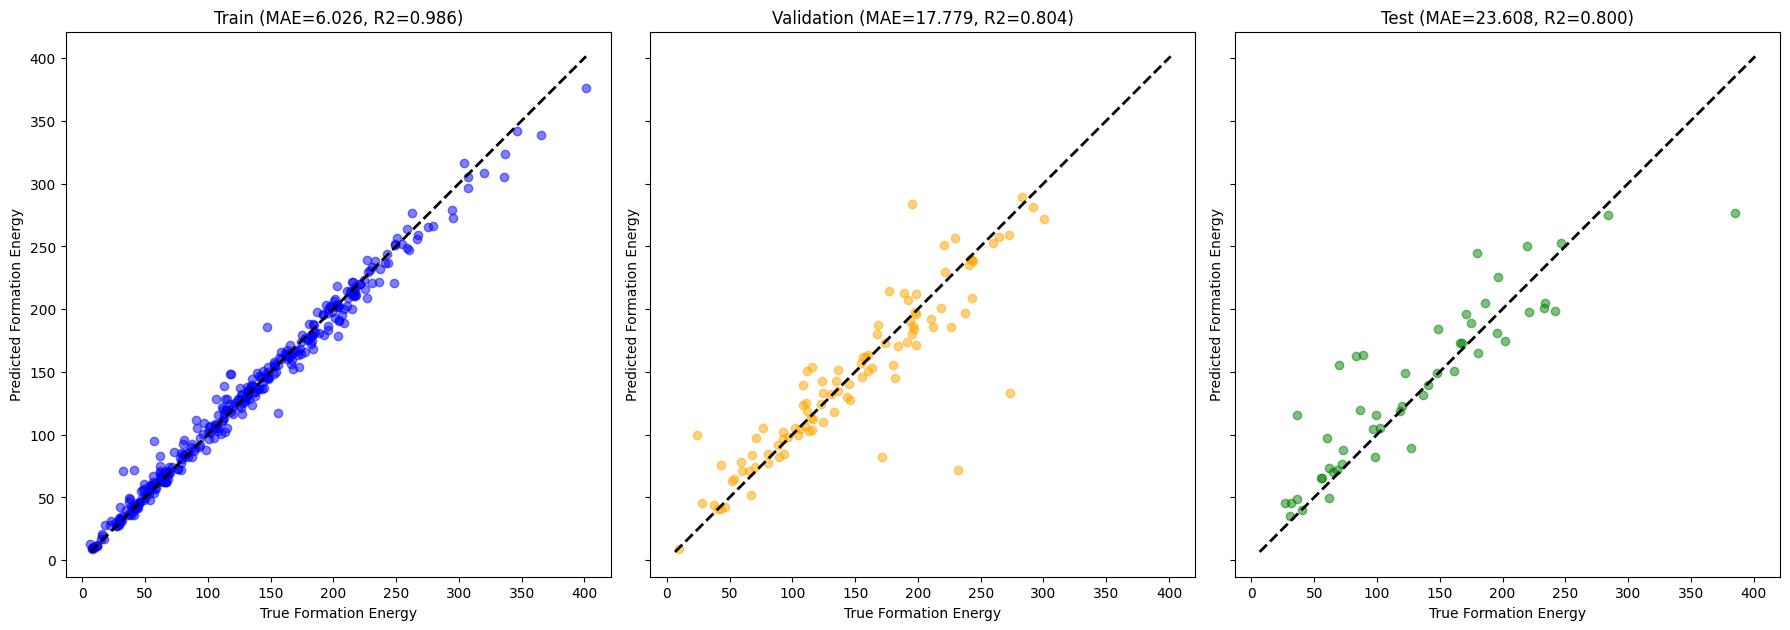

In [6]:
final_features = selected_features_dict[25]
rf_final = RandomForestRegressor(n_estimators=100, random_state=17, n_jobs=1)
X_train_final = X_train[:, [X.columns.get_loc(f) for f in final_features]]
rf_final.fit(X_train_final, y_train)

X_val_final = X_val[:, [X.columns.get_loc(f) for f in final_features]]
X_test_final = X_test[:, [X.columns.get_loc(f) for f in final_features]]

y_train_pred = rf_final.predict(X_train_final)
y_val_pred = rf_final.predict(X_val_final)
y_test_pred = rf_final.predict(X_test_final)

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_val, y_val_pred)
r2_test = r2_score(y_test, y_test_pred)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
min_val = 0.0
max_val = 5.0

min_val = min(y_train.min(), y_val.min(), y_test.min(),
              y_train_pred.min(), y_val_pred.min(), y_test_pred.min())
max_val = max(y_train.max(), y_val.max(), y_test.max(),
              y_train_pred.max(), y_val_pred.max(), y_test_pred.max())

axes[0].scatter(y_train, y_train_pred, alpha=0.5, color='blue')
axes[0].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
axes[0].set_title(f'Train (MAE={mae_train:.3f}, R2={r2_train:.3f})')
axes[0].set_xlabel('True Formation Energy')
axes[0].set_ylabel('Predicted Formation Energy')
axes[0].set_aspect('equal', adjustable='box')

axes[1].scatter(y_val, y_val_pred, alpha=0.5, color='orange')
axes[1].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
axes[1].set_title(f'Validation (MAE={mae_val:.3f}, R2={r2_val:.3f})')
axes[1].set_xlabel('True Formation Energy')
axes[1].set_ylabel('Predicted Formation Energy')
axes[1].set_aspect('equal', adjustable='box')

axes[2].scatter(y_test, y_test_pred, alpha=0.5, color='green')
axes[2].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
axes[2].set_title(f'Test (MAE={mae_test:.3f}, R2={r2_test:.3f})')
axes[2].set_xlabel('True Formation Energy')
axes[2].set_ylabel('Predicted Formation Energy')
axes[2].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

In [37]:
from dscribe.descriptors import EwaldSumMatrix
from pymatgen.io.ase import AseAtomsAdaptor
import numpy as np
import pandas as pd

n_max = max(len(mat) for mat in df['structure'])
print(f"Max atoms per structure: {n_max}")

ews = EwaldSumMatrix(n_atoms_max=n_max, permutation="eigenspectrum")

ase_structures = [AseAtomsAdaptor.get_atoms(struc) for struc in df['structure']]
ews_matrices = np.array(ews.create(ase_structures))

ews_columns = [f"ews_{i}" for i in range(ews_matrices.shape[1])]
df_featurized_ews = pd.concat(
    [df.reset_index(drop=True),
     pd.DataFrame(ews_matrices, columns=ews_columns)],
    axis=1
)

print(f"Shape after EwaldSumMatrix featurization: {df_featurized_ews.shape}")




Max atoms per structure: 152
Shape after EwaldSumMatrix featurization: (500, 172)


In [38]:
ews_columns = [f'ews_{i}' for i in range(ews_matrices.shape[1])]
df_featurized_ews = df.copy()
df_featurized_ews[ews_columns] = pd.DataFrame(ews_matrices, index=df_featurized_ews.index)
print(df_featurized_ews.head())


    material_id  formula  nsites  space_group      volume  \
940   mp-568671    V5Si3      32          140  418.062173   
853       mp-49       Os       2          194   28.725857   
814     mp-3803  Ta4AlC3      16          194  206.310132   
473    mp-20730  HfCo2Sn      16          225  244.961386   
169    mp-11807     LiPt       2          187   28.048366   

                                             structure  elastic_anisotropy  \
940  [[8.69590204 2.1136965  2.3661105 ] V, [4.6995...            0.170758   
853  [[1.37997771 0.7967292  3.26588025] Os, [-1.71...            0.018442   
814  [[1.55237222 0.89626077 8.42116872] Ta, [-1.21...            0.020371   
473  [[0.       3.128498 0.      ] Hf, [0.       0....            0.264730   
169  [[-1.71552700e-06  1.59602013e+00  2.11909000e...            1.966236   

        G_Reuss       G_VRH     G_Voigt  ...  ews_142  ews_143  ews_144  \
940  117.946009  119.912762  121.879516  ...      0.0      0.0      0.0   
853  258.28420

C:\Users\51648\AppData\Local\Temp\ipykernel_21072\1194363577.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_featurized_ews[ews_columns] = pd.DataFrame(ews_matrices, index=df_featurized_ews.index)
C:\Users\51648\AppData\Local\Temp\ipykernel_21072\1194363577.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_featurized_ews[ews_columns] = pd.DataFrame(ews_matrices, index=df_featurized_ews.index)
C:\Users\51648\AppData\Local\Temp\ipykernel_21072\1194363577.py:3: PerformanceWarning: DataFrame is highly fragmented.  This i

Number of features before cleaning: 157
Number of features after removing small variance columns: 154
Number of features after removing highly correlated columns: 41


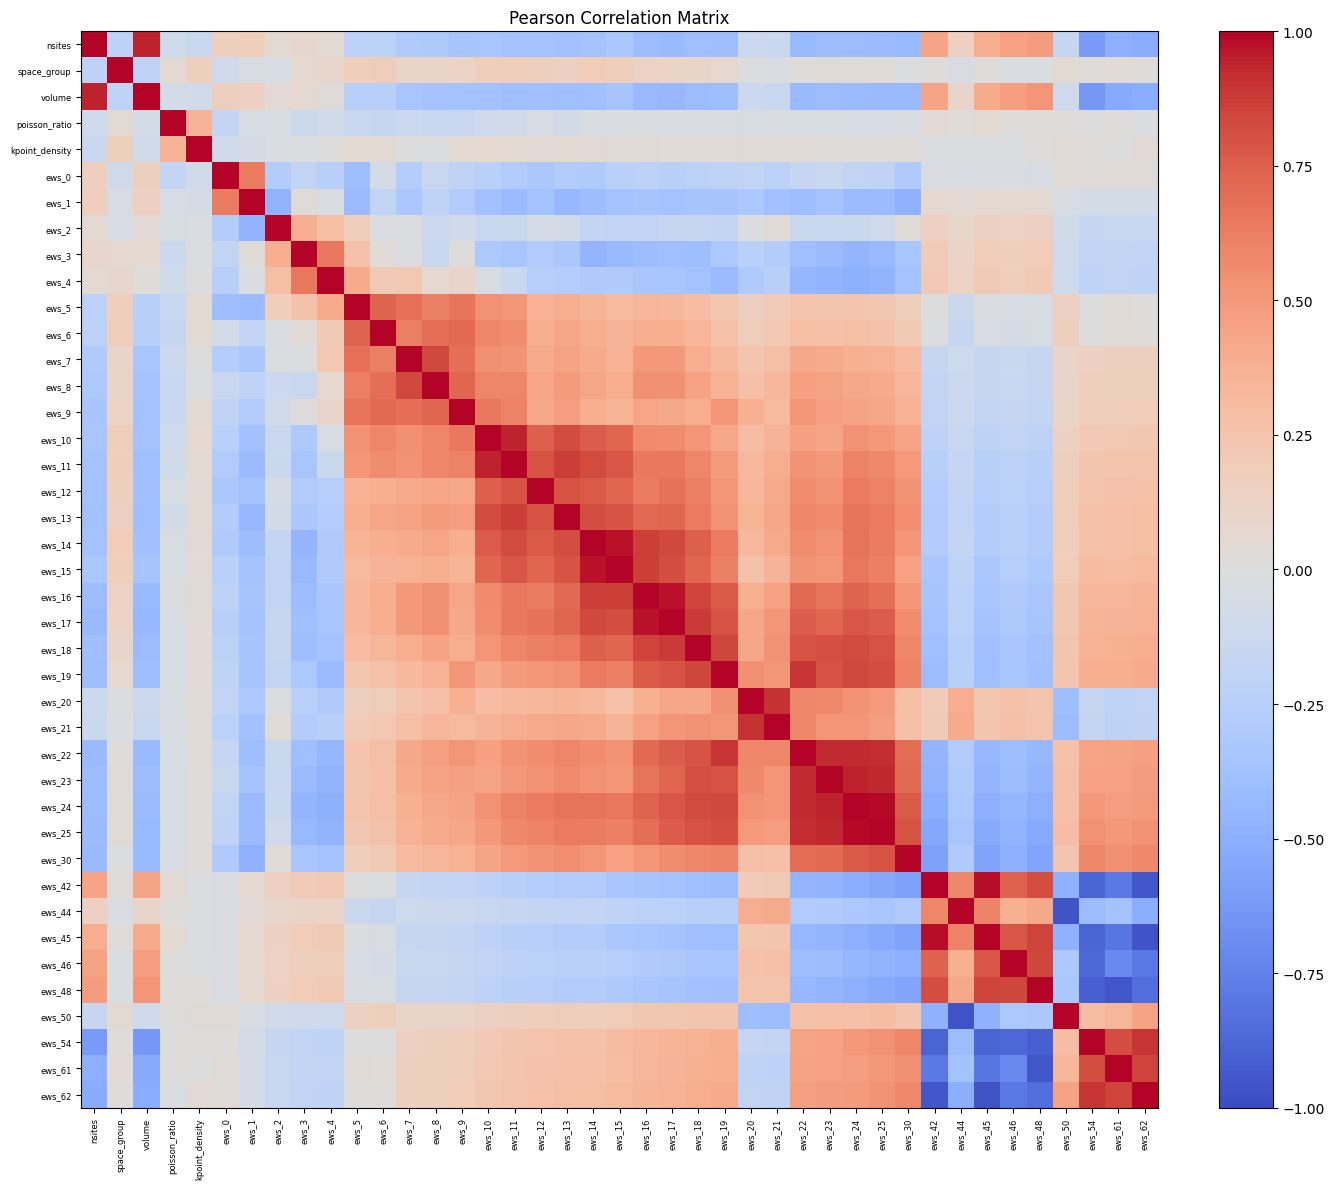

In [39]:
y = df_featurized_ews['K_VRH']
cols_to_drop = [
    'elastic_anisotropy', 'G_Reuss', 'G_VRH', 'G_Voigt',
    'K_Reuss', 'K_Voigt', 'elastic_tensor', 'compliance_tensor'
]
X_all_struc = df_featurized_ews.drop(columns=cols_to_drop, errors='ignore')
X_all_struc = X_all_struc.select_dtypes(include=['float64', 'int64'])
X_all_struc = X_all_struc.drop(columns='K_VRH', errors='ignore')

print("Number of features before cleaning:", X_all_struc.shape[1])

small_var_cols_struc = X_all_struc.columns[X_all_struc.var() < 1e-5].tolist()

X_all_struc = X_all_struc.drop(columns=small_var_cols_struc)
corr_matrix_struc = X_all_struc.corr(method='pearson')
print("Number of features after removing small variance columns:", X_all_struc.shape[1])

threshold = 0.99
to_drop_struc = set()
for col in corr_matrix_struc.columns:
    high_corr_struc = corr_matrix_struc.index[(corr_matrix_struc[col].abs() > threshold) & (corr_matrix_struc.index != col)]
    to_drop_struc.update(high_corr_struc)
X_struc = X_all_struc.drop(columns=list(to_drop_struc))
print("Number of features after removing highly correlated columns:", X_struc.shape[1])

corr_matrix_struc = X_struc.corr(method='pearson')

plt.figure(figsize=(16, 12))
im = plt.imshow(corr_matrix_struc, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title('Pearson Correlation Matrix')
plt.xticks(range(len(corr_matrix_struc.columns)), [str(c) for c in corr_matrix_struc.columns], rotation=90, fontsize=6)
plt.yticks(range(len(corr_matrix_struc.columns)), [str(c) for c in corr_matrix_struc.columns], fontsize=6)
plt.tight_layout()
plt.show()

In [29]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_struc)

test_fraction = 0.1
validation_fraction = 0.2
X_trainval, X_test, y_trainval, y_test = train_test_split(X_scaled, y, 
                                                          test_size=test_fraction, 
                                                          random_state=17)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, 
                                                  test_size=validation_fraction/(1-test_fraction), 
                                                  random_state=17)
print(f"Training fraction: {X_train.shape[0] / X_scaled.shape[0]:.2f}")
print(f"Validation fraction: {X_val.shape[0] / X_scaled.shape[0]:.2f}")
print(f"Test fraction: {X_test.shape[0] / X_scaled.shape[0]:.2f}")

Training fraction: 0.70
Validation fraction: 0.20
Test fraction: 0.10


In [31]:
mean_train = y_train.mean()
baseline_mae = mean_absolute_error(y_val, [mean_train] * len(y_val))
print(f"Baseline MAE (predicting mean formation energy): {baseline_mae:.4f} eV")

Baseline MAE (predicting mean formation energy): 58.9539 eV


Training RF models:   0%|          | 0/4 [00:00<?, ?it/s]

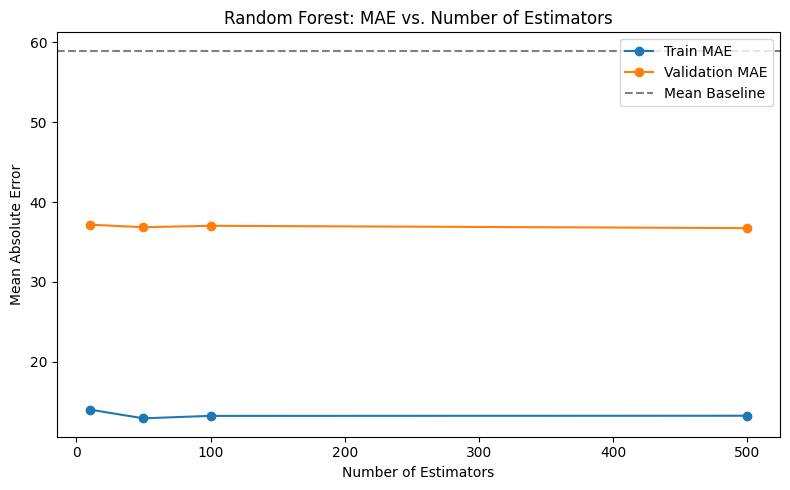

In [32]:
n_estimators_list = [10, 50, 100, 500]
train_maes = []
val_maes = []

for n in tqdm(n_estimators_list, desc='Training RF models'):
    rf = RandomForestRegressor(n_estimators=n, random_state=17, n_jobs=1)
    rf.fit(X_train, y_train)
    y_train_pred = rf.predict(X_train)
    y_val_pred = rf.predict(X_val)
    train_maes.append(mean_absolute_error(y_train, y_train_pred))
    val_maes.append(mean_absolute_error(y_val, y_val_pred))

plt.figure(figsize=(8, 5))
plt.plot(n_estimators_list, train_maes, marker='o', label='Train MAE')
plt.plot(n_estimators_list, val_maes, marker='o', label='Validation MAE')
plt.axhline(baseline_mae, color='gray', linestyle='--', label='Mean Baseline')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Absolute Error')
plt.title('Random Forest: MAE vs. Number of Estimators')
plt.legend()
plt.tight_layout()
plt.show()

RFE Progress:   0%|          | 0/8 [00:00<?, ?it/s]

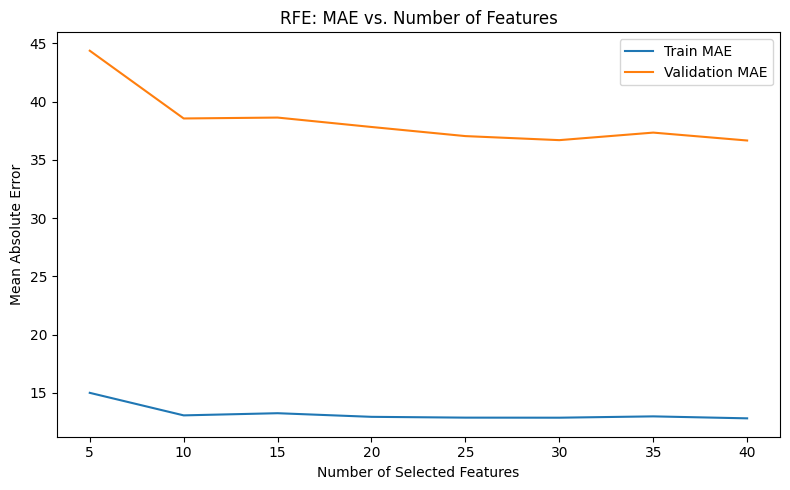

In [33]:
rf = RandomForestRegressor(n_estimators=50, random_state=17, n_jobs=1)
n_features_list = list(range(5, X_val.shape[1] + 1, 5))
val_errors = []
train_errors = []
selected_features_dict = {}

for n_features in tqdm(n_features_list, desc='RFE Progress'):
    rfe = RFE(estimator=rf, n_features_to_select=n_features, step=10)
    rfe.fit(X_train, y_train)
    selected_features_dict[n_features] = list(X_struc.columns[rfe.support_])
    X_train_rfe = rfe.transform(X_train)
    rf.fit(X_train_rfe, y_train)
    y_train_pred = rf.predict(X_train_rfe)
    train_errors.append(mean_absolute_error(y_train, y_train_pred))
    X_val_rfe = rfe.transform(X_val)
    y_val_pred = rf.predict(X_val_rfe)
    val_errors.append(mean_absolute_error(y_val, y_val_pred))

plt.figure(figsize=(8, 5))
plt.plot(n_features_list, train_errors, label='Train MAE')
plt.plot(n_features_list, val_errors, label='Validation MAE')
plt.xlabel('Number of Selected Features')
plt.ylabel('Mean Absolute Error')
plt.title('RFE: MAE vs. Number of Features')
plt.legend()
plt.tight_layout()
plt.show()

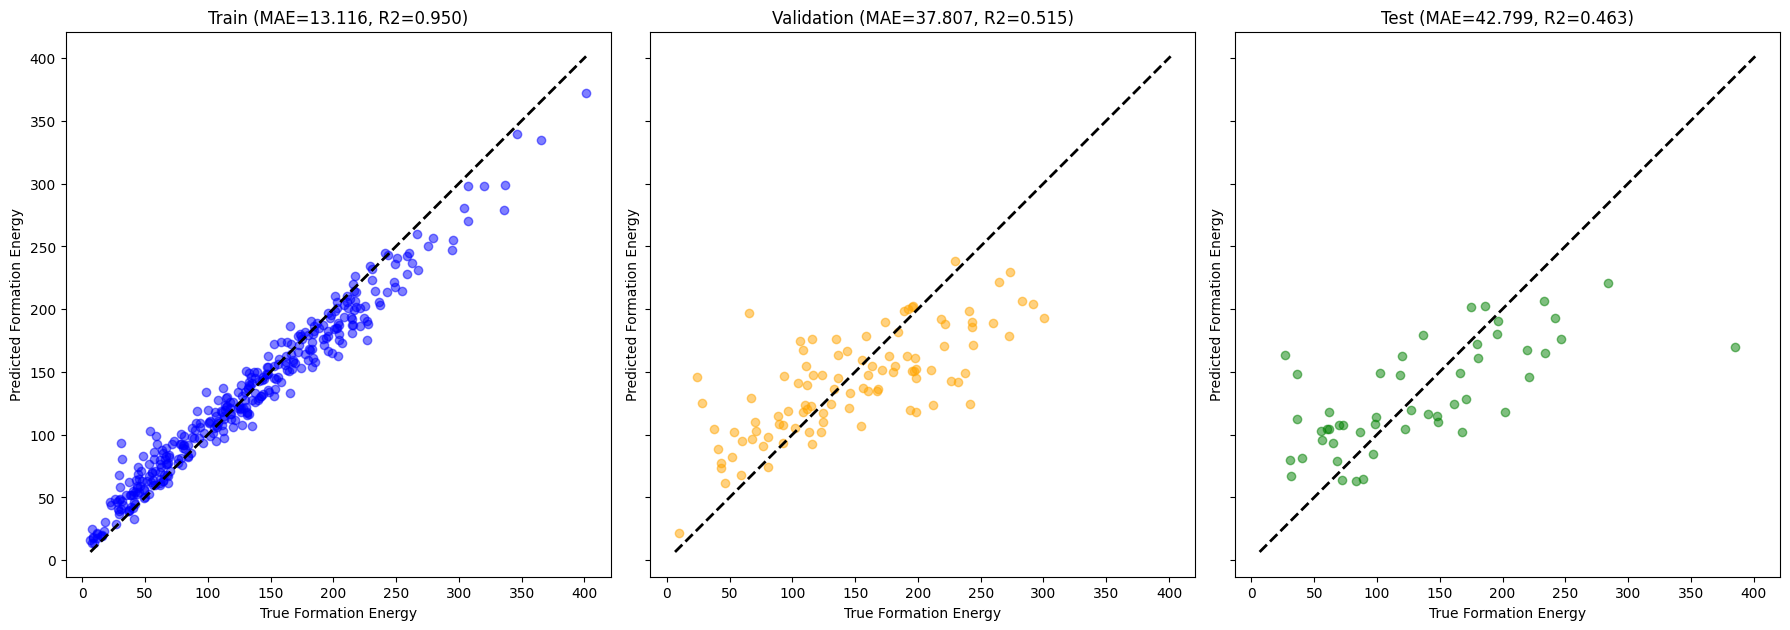

In [ ]:
from sklearn.metrics import r2_score

final_features = selected_features_dict[20]
rf_final = RandomForestRegressor(n_estimators=100, random_state=17, n_jobs=1)
X_train_final = X_train[:, [X_struc.columns.get_loc(f) for f in final_features]]
rf_final.fit(X_train_final, y_train)
X_val_final = X_val[:, [X_struc.columns.get_loc(f) for f in final_features]]
X_test_final = X_test[:, [X_struc.columns.get_loc(f) for f in final_features]]
y_train_pred = rf_final.predict(X_train_final)
y_val_pred = rf_final.predict(X_val_final)
y_test_pred = rf_final.predict(X_test_final)

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_val, y_val_pred)
r2_test = r2_score(y_test, y_test_pred)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
min_val = min(y_test.min(), y_val.min(), y_train.min())
max_val = max(y_test.max(), y_val.max(), y_train.max())

axes[0].scatter(y_train, y_train_pred, alpha=0.5, color='blue')
axes[0].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
axes[0].set_title(f'Train (MAE={mae_train:.3f}, R2={r2_train:.3f})')
axes[0].set_xlabel('True Formation Energy')
axes[0].set_ylabel('Predicted Formation Energy')
axes[0].set_aspect('equal', adjustable='box')

axes[1].scatter(y_val, y_val_pred, alpha=0.5, color='orange')
axes[1].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
axes[1].set_title(f'Validation (MAE={mae_val:.3f}, R2={r2_val:.3f})')
axes[1].set_xlabel('True Formation Energy')
axes[1].set_ylabel('Predicted Formation Energy')
axes[1].set_aspect('equal', adjustable='box')

axes[2].scatter(y_test, y_test_pred, alpha=0.5, color='green')
axes[2].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
axes[2].set_title(f'Test (MAE={mae_test:.3f}, R2={r2_test:.3f})')
axes[2].set_xlabel('True Formation Energy')
axes[2].set_ylabel('Predicted Formation Energy')
axes[2].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

In [ ]:
#The model based on structure-derived features (EwaldSumMatrix) shows lower predictive performance compared to composition-based features.
#Because structural descriptors like EwaldSumMatrix are high-dimensional and sensitive to small geometric variations, 
#which makes them less robust for small datasets.
#In contrast, composition-based descriptors such as Magpie capture averaged elemental properties and are easier to learn for models like Random Forest.
#Therefore, the observed performance gap does not indicate an implementation error, 
# but rather reflects the intrinsic limitations of this descriptor and dataset size.